In [136]:
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from matplotlib import colors as mcolors
import numpy as np
from statsmodels.stats.proportion import proportions_ztest
from scipy.stats import mannwhitneyu


# A/B–тестирование
Одной из основных задач аналитика в нашей команде является корректное проведение экспериментов.   
Для этого мы применяем метод A/B–тестирования.   
В ходе тестирования одной гипотезы целевой группе была предложена новая механика оплаты услуг на сайте, у контрольной группы оставалась базовая механика.   
Необходимо проанализировать итоги эксперимента и сделать вывод, стоит ли запускать новую механику оплаты на всех пользователей.


## Гипотеза H0: новая механика оплаты не повлияет на рост выручки (GMV)

In [137]:
# Принадлежность пользователя к контрольной или экспериментальной группе (А – контроль, B – целевая группа) 
groups = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-egor-naberezhnov-e-a013a/final_project/data/groups.csv', sep=';')
groups.head() 

,id,grp
0,1489,B
1,1627,A
2,1768,B
3,1783,B
4,1794,A


In [138]:
# Пользователи, которых прислали спустя 2 дня после передачи данных 'groups'
group_add = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-egor-naberezhnov-e-a013a/final_project/data/group_add.csv', sep=',')
group_add.head()

,id,grp
0,5694584,B
1,5694830,B
2,5695057,B
3,5698872,B
4,5699067,B


In [139]:
# Пользователи, которые зашли на платформу в дни проведения эксперимента. 
active_studs = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-egor-naberezhnov-e-a013a/final_project/data/active_studs.csv')

# Добавляем пометку 'active' для всех пользователей online во время теста
active_studs['active'] = 'active'
active_studs.head()

,student_id,active
0,581585,active
1,5723133,active
2,3276743,active
3,4238589,active
4,4475369,active


In [140]:
# Информация об оплатах пользователей в дни проведения эксперимента. 
checks = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-egor-naberezhnov-e-a013a/final_project/data/checks.csv', sep=';')
checks.head()

,student_id,rev
0,1627,990.0
1,3185,690.0
2,25973,690.0
3,26280,690.0
4,100300,990.0


In [141]:
# Проверка на отсутствующие значений
datasets = {
    'groups': groups,
    'group_add': group_add,
    'active_studs': active_studs,
    'checks': checks
}

for name, df in datasets.items():
    print(f"\nПропущенные значения в {name}:")
    print(df.isna().sum())


Пропущенные значения в groups:
id     0
grp    0
dtype: int64

Пропущенные значения в group_add:
id     0
grp    0
dtype: int64

Пропущенные значения в active_studs:
student_id    0
active        0
dtype: int64

Пропущенные значения в checks:
student_id    0
rev           0
dtype: int64


In [142]:
# Делаем общий ДФ из group и принесенных позже group_add
all_users_and_groups = pd.concat([groups, group_add], ignore_index=True)
all_users_and_groups = all_users_and_groups.rename(columns={'id': 'student_id'})

# Объединяем данные, заменяем пустые значения.
all_users = (all_users_and_groups.merge(active_studs, on='student_id', how='outer')
                                 .merge(checks, on='student_id', how='outer'))
all_users['active'] = all_users['active'].fillna('non-active')
all_users['rev'] = all_users['rev'].fillna(0)

all_users.head()

,student_id,grp,active,rev
0,1489,B,non-active,0.0
1,1627,A,active,990.0
2,1768,B,non-active,0.0
3,1783,B,non-active,0.0
4,1794,A,non-active,0.0


Сравним количество user в обеих группах, в том числе активных.

In [143]:
grA_count = all_users.query("grp == 'A'").student_id.nunique()
grA_count_active = all_users.query("grp == 'A' & active == 'active'").student_id.nunique()

grB_count = all_users.query("grp == 'B'").student_id.nunique()
grB_count_active = all_users.query("grp == 'B' & active == 'active'").student_id.nunique()

# Процент активных пользователей Activity Rate (AR) от общего количества по группам
AR_grA = round((grA_count_active / grA_count) * 100,2)
AR_grB = round((grB_count_active / grB_count) * 100,2)

print(f"Большая разница в размере выборок групп A и B")
print(f"\nРазмер выборки контрольной группы A = {grA_count} человек")
print(f"Активная аудитория контрольной группы A = {grA_count_active} человек. Ее доля составляет {AR_grA}%")

print(f"\nРазмер выборки контрольной группы B = {grB_count} человек")
print(f"Активная аудитория контрольной группы B = {grB_count_active} человек. Ее доля составляет {AR_grB}%")

Большая разница в размере выборок групп A и B

Размер выборки контрольной группы A = 14693 человек
Активная аудитория контрольной группы A = 1538 человек. Ее доля составляет 10.47%

Размер выборки контрольной группы B = 59883 человек
Активная аудитория контрольной группы B = 6803 человек. Ее доля составляет 11.36%


Посмотрим на разницу визуально

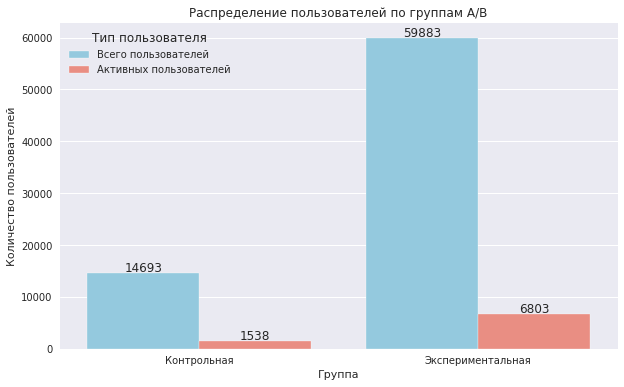

In [144]:
# Создаем данные для графика
plot_data = pd.DataFrame({
    'Group': ['Контрольная', 'Контрольная', 'Экспериментальная', 'Экспериментальная'],
    'Type': ['Всего пользователей', 'Активных пользователей', 'Всего пользователей', 'Активных пользователей'],
    'Count': [
        grA_count,  # Всего в группе A
        grA_count_active,  # Активных в A
        grB_count,  # Всего в группе B
        grB_count_active  # Активных в B
    ]
})

# Создаем барплот
plt.figure(figsize=(10, 6))
sns.barplot(x='Group', y='Count', hue='Type', data=plot_data, palette=['skyblue', 'salmon'])

plt.title('Распределение пользователей по группам A/B')
plt.ylabel('Количество пользователей')
plt.xlabel('Группа')
plt.legend(title='Тип пользователя')

# Добавляем подписи значений
for p in plt.gca().patches:
    plt.gca().annotate(f'{int(p.get_height())}', 
                      (p.get_x() + p.get_width() / 2., p.get_height()), 
                      ha='center', va='center', 
                      xytext=(0, 5), 
                      textcoords='offset points')

plt.show()

Готовим данные для расчета метрик

In [145]:
# Присваеваем статус user, совершившие оплату. 1 - оплатили, 0 - не оплатили.
active_users = all_users.query("active == 'active'")
active_users['paid_users'] = active_users['rev'].apply(lambda x: 1 if x > 0 else 0)

group_stats = (active_users
               .groupby('grp', as_index=False)
               .agg(
                   total_users=('active', 'count'),
                   paid_users=('paid_users', 'sum'),
                   revenue=('rev', 'sum')
               )
              )

group_stats['revenue'] = round(group_stats['revenue'],0)

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


Считаем метрики

In [146]:
group_stats['CR_to_pay'] = round((group_stats.paid_users / group_stats.total_users)*100,2)
group_stats['ARPU'] = round((group_stats.revenue / group_stats.total_users),2)
group_stats['ARPPU'] = round((group_stats.revenue / group_stats.paid_users),2)
group_stats


,grp,total_users,paid_users,revenue,CR_to_pay,ARPU,ARPPU
0,A,1538,78,72820.0,5.07,47.35,933.59
1,B,6803,314,394974.0,4.62,58.06,1257.88


Проверяем распределения на нормальность.  
Возьмем чистые данные по выручке и логарифмированные.

In [147]:
gr_a = active_users.query("paid_users == 1 & grp == 'A'").rev
gr_b = active_users.query("paid_users == 1 & grp == 'B'").rev

# Логарифмирование с обработкой нулей
log_revenue_a = np.log1p(gr_a)
log_revenue_b = np.log1p(gr_b)

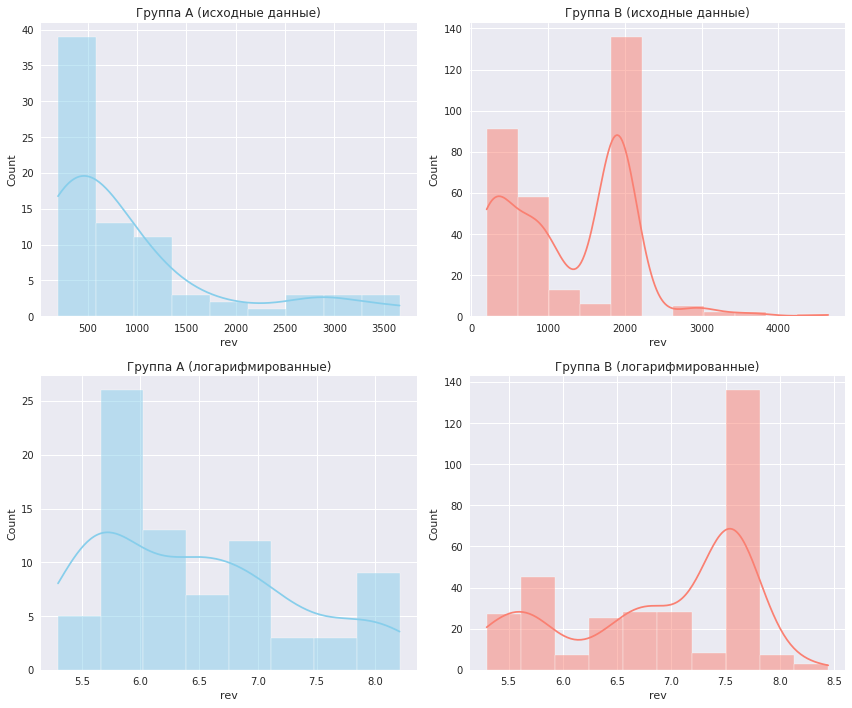

In [148]:
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# До преобразования
sns.histplot(gr_a, ax=axes[0, 0], kde=True, color='skyblue')
axes[0, 0].set_title('Группа A (исходные данные)')
sns.histplot(gr_b, ax=axes[0, 1], kde=True, color='salmon')
axes[0, 1].set_title('Группа B (исходные данные)')

# После преобразования
sns.histplot(log_revenue_a, ax=axes[1, 0], kde=True, color='skyblue')
axes[1, 0].set_title('Группа A (логарифмированные)')
sns.histplot(log_revenue_b, ax=axes[1, 1], kde=True, color='salmon')
axes[1, 1].set_title('Группа B (логарифмированные)')

plt.tight_layout()
plt.show()

In [149]:
from scipy.stats import shapiro

_, p_a = shapiro(gr_a)
_, p_b = shapiro(gr_b)
print(f"Нормальность: Group A (p={p_a:.3f}), Group B (p={p_b:.3f})")

Нормальность: Group A (p=0.000), Group B (p=0.000)


По визуальным данным и с помощью Shapiro-Wilk убедились, что обе группы платящих пользователей имеют ненормальное распределение. Соответветственно используем: z-test, Мана-Уитни и/или bootstrap.



## Для выявления статистически значимых различий между группами A и B будем сравнивать:
1. Конверсию в покупку CR_to_pay через сравнение total_users и paid_users по средствам z-test;
2. ARPU через сравнение revenue и total_users по средствам теста Манна-Уитни;
3. ARPPU через сравнение revenue и paid_users по средствам теста Манна-Уитни.


## 1. Z-Test (CR_to_pay) 
Группа A: 78 оплат из 1538 пользователей (CR = 5.07%).  
Группа B: 314 оплат из 6803 пользователей (CR = 4.62%).

H0: Новый способ оплаты не повысит конверсию в группе B.  
H1: Новый способ оплаты повысит конверсию в группе B.

In [150]:
paid_users = [78, 314]     
total_users = [1538, 6803]    

z_stat, p_value = proportions_ztest(paid_users, total_users, alternative='two-sided')
print(f"Результаты Z-теста: z-статистика = {z_stat:.3f}, \np-value = {p_value:.4f} > 0.05 → различия статистически незначимы.")


Результаты Z-теста: z-статистика = 0.763, 
p-value = 0.4455 > 0.05 → различия статистически незначимы.


## Заключение z-test по конверсии: 
Новая механика оплаты (группа B) не показала статистически значимого изменения конверсии по сравнению с контрольной группой A.  
Принимаем H0: Новый способ оплаты не повысит конверсию в группе B.


## 2. ARPU между группами:
Группа A: 47.35  
Группа B: 58.06

H0: Новый способ оплаты не повысит ARPU в группе B.  
H1: Новый способ оплаты повысит ARPU в группе B.



In [151]:
gr_a_total = active_users.query("grp == 'A'").rev
gr_b_total = active_users.query("grp == 'B'").rev

stat, p_value = mannwhitneyu(gr_a_total, gr_b_total, alternative='two-sided')

print(f"Результаты теста: U-статистика = {stat:.1f}, p-value = {p_value:.4f} > 0.05 → различия статистически незначимы.")


Результаты теста: U-статистика = 5252113.0, p-value = 0.5100 > 0.05 → различия статистически незначимы.


## Заключение теста Манна-Уитни по ARPU:   
Новая механика оплаты (группа B) не показала статистически значимого изменения ARPU по сравнению с контрольной группой A.   
При этом есть видимая удельная разница между группами в 18,45%, которая могла бы быть обусловлена критическими выбросами в группе B.  
Принимаем H0: Новый способ оплаты не повысит ARPU в группе B.

## Попробуем сравнить доверительные интервалы средних с помощью бутстрапа

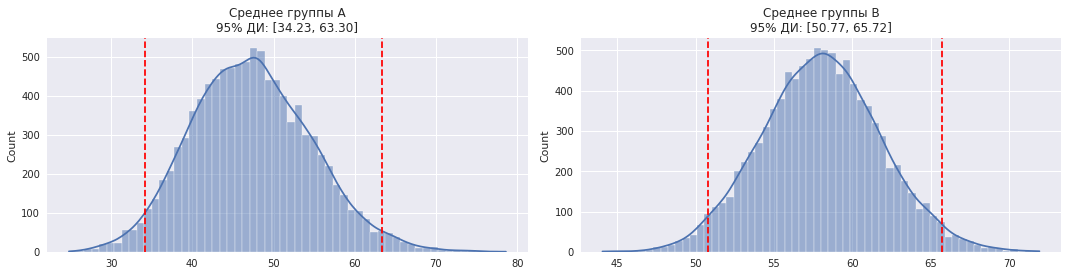

In [152]:
import pingouin as pg

# Расчёт ДИ для средних 2 групп
ci_mean_grA = pg.compute_bootci(gr_a_total, func=np.mean, confidence=0.95, n_boot=10000, return_dist=True)
ci_mean_grB = pg.compute_bootci(gr_b_total, func=np.mean, confidence=0.95, n_boot=10000, return_dist=True)

# Визуализация распределения бутстреп-статистик
fig, axes = plt.subplots(1, 2, figsize=(15, 4))
titles = ['Среднее группы А', 'Среднее группы B']
cis = [ci_mean_grA, ci_mean_grB]

for ax, title, (ci, dist) in zip(axes, titles, cis):
    sns.histplot(dist, ax=ax, kde=True)
    ax.axvline(ci[0], color='red', linestyle='--')
    ax.axvline(ci[1], color='red', linestyle='--')
    ax.set_title(f"{title}\n95% ДИ: [{ci[0]:.2f}, {ci[1]:.2f}]")

plt.tight_layout()
plt.show()

## Заключение теста бутстрепа по ARPU:   
ARPU группы B (95% ДИ: [50.61, 65.43]) статистически незначимо превышает группу A (95% ДИ: [34.05, 63.41]).

## 3. ARPPU между группами:
Группа A: 933.59  
Группа B: 1257.88

H0: Новый способ оплаты не повысит ARPPU в группе B.  
H1: Новый способ оплаты повысит ARPPU в группе B.

In [153]:
stat, p_value = mannwhitneyu(gr_a, gr_b, alternative='two-sided')

print(f"Результаты теста: U-статистика = {stat:.1f}, p-value = {p_value:.4f} < 0.05 → различия статистически значимы.")


Результаты теста: U-статистика = 9001.0, p-value = 0.0003 < 0.05 → различия статистически значимы.


## Заключение теста Манна-Уитни по ARPPU:
Новая механика оплаты (группа B) показала статистически значимые изменения ARPPU по сравнению с контрольной группой A.  При этом ARPPU в группе **B** больше на 25%.    
Принимаем H1: Новый способ оплаты повысит ARPPU в группе B.

# Заключение по А/B тестированию
В результате выявления статзначимых различий между группами А и B по ARPPU, новую фичу можем раскатывать на всех пользователей.   
При этом конверсия в оплату группы B была ниже, чем в группе А. Но данная разница оказалась не статзначимой.

Принимаем H1: новая механика оплаты повлияет на рост выручки (GMV)